# This project focused on the task of text classification based on emotion analysis. Six categories were used to identify emotions in texts: Joy, Sadness, Anger, Fear, Love, and Surprise.



# Project Goal

The main goal was to design and train a neural network to automatically classify texts based on emotions using preprocessed data and a pre-trained embedding layer.

In [1]:
import nltk
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/README  
  inflating: /kaggle/w

In [4]:
df = pd.read_csv("/kaggle/input/emotions/text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

# 1. Text preprocessing:
 - NLTK library for text processing was used.
 - In the first step, performed text cleanup which includes removing HTML tags, URLs, short words, numbers, bringing the text to lower case and removing extra spaces.
 - Removed stop words and performed lemmatization to bring words to a basic form.
 - Visualized the text before and after processing to demonstrate the effect of pre-processing.

In [7]:
def preprocess_text(text):
    # Delete HTML tags
    text = re.sub(r'<.*?>', '', text)
    # URL Delete
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove repeating characters (e.g. cooool -> cool)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Delete short words (1-2 characters)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Deleting numbers
    text = re.sub(r'\d+', '', text)
    # Lowercase
    text = text.lower()
    # Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}  # Remove stopwords except negations
    lemmatizer = WordNetLemmatizer()

    # Tokenize text to handle negations like isn't, wasn't, aren't, etc.

    tokens = nltk.word_tokenize(text)
    tokens_lemmatized = []

    for token in tokens:
        if token in stop_words:
            continue
        if token in ['not', 'no', 'nor']:
            tokens_lemmatized.append(token)
        elif token.endswith("n't"):
            tokens_lemmatized.append(token)  # Keep contractions like "isn't"
        else:
            tokens_lemmatized.append(lemmatizer.lemmatize(token))

    text = ' '.join(tokens_lemmatized)

    return text

In [8]:
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df['preprocessed_text_len'] = df['preprocessed_text'].apply(len)

#  2. Analyzed and balanced the classes:
 - Determined that there was an imbalance between classes.  Some emotions were presented much less than others.

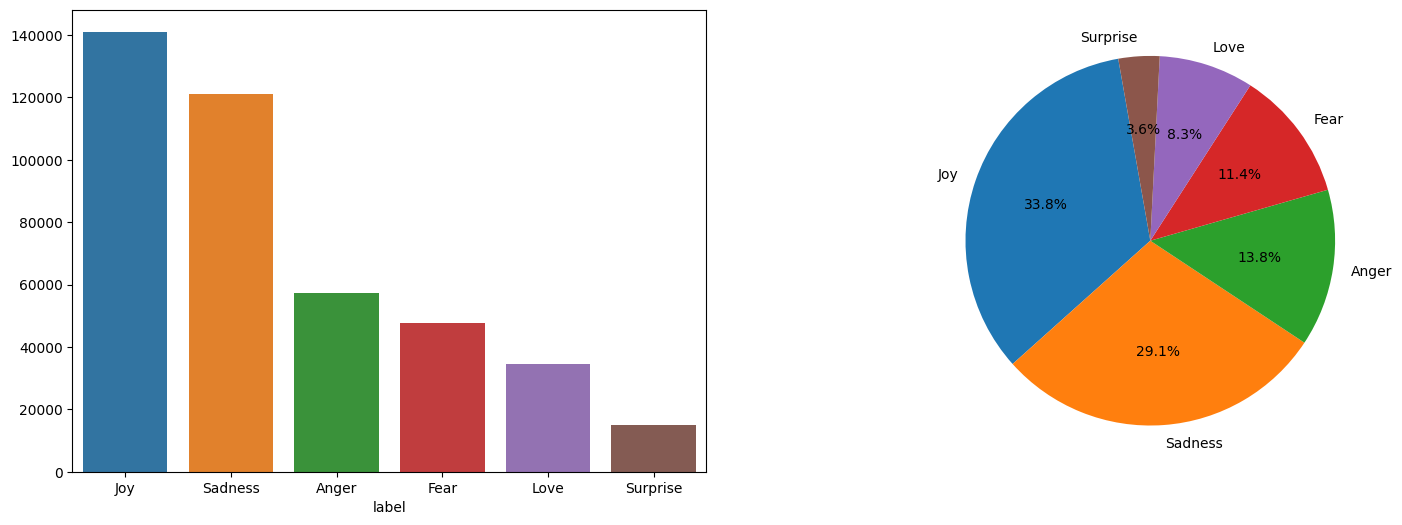

In [9]:
counts = df['label'].value_counts()

label_names = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

counts.index = counts.index.map(label_names)

fig, axs = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')
sns.barplot(x=counts.index, y=counts.values, ax=axs[0])
axs[1].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=100)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

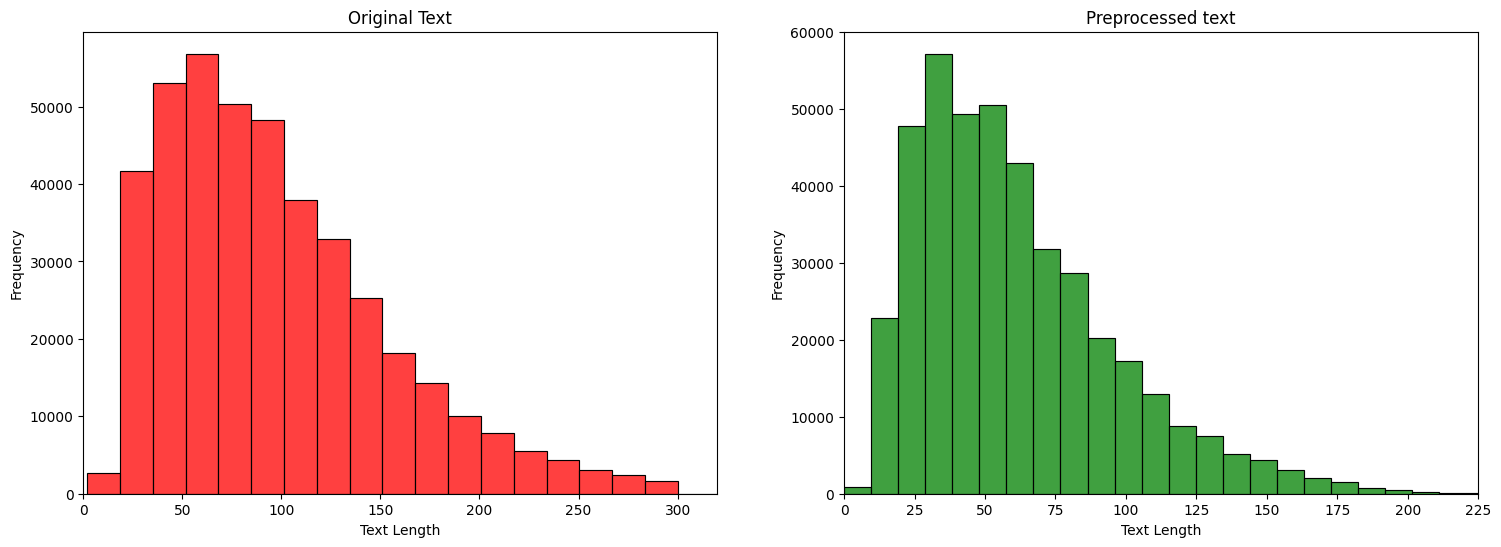

In [10]:
df['text_len'] = df['text'].apply(len)

fig,ax = plt.subplots(1,2, figsize=(18, 6))
sns.histplot(x=df['text_len'], bins = 50, color='r', ax = ax[0])
ax[0].set_xlim(0,320)
ax[0].set_title('Original Text')
ax[0].set_xlabel('Text Length')
ax[0].set_ylabel('Frequency')

sns.histplot(x=df['preprocessed_text_len'], bins = 50, color='green', ax = ax[1])
ax[1].set_xlim(0,225)
ax[1].set_title('Preprocessed text')
ax[1].set_xlabel('Text Length')
ax[1].set_ylabel('Frequency')

In [11]:
a = df['text_len'].mean()
b = df['preprocessed_text_len'].mean()

print(f'Mean length of text without pre-preparation {round(a,0)}')
print(f'Mean length of text with pre-preparation {round(b, 0)}')

Mean length of text without pre-preparation 97.0
Mean length of text with pre-preparation 61.0


In [12]:
# Get the maximum length of text in the original text column

max_length_original = df['text_len'].max()
print("Maximum length of text in original column:", max_length_original)

# Get the maximum length of text in the preprocessed text column
max_length_preprocessed = df['preprocessed_text_len'].max()
print("Maximum length of text in preprocessed column:", max_length_preprocessed)

Maximum length of text in original column: 830
Maximum length of text in preprocessed column: 480


In [13]:
data = pd.DataFrame()
data['text'] = df['preprocessed_text']

In [14]:
data['label'] = df['label']

In [15]:
data.sample(10)

,text,label
149422,feel though might get blamed though ive enthus...,0
299587,cried feeling rejected bit,0
386023,still feeling pretty skeptical,4
32361,want eat ill feeling bit delicate,2
71669,feeling bitter american guide ireland found am...,3
4554,told worker feel giggly silly today,1
304457,feeling depressed lonely imagine would love so...,0
23772,feel blessed peace even despite worry challeng...,2
126584,havent feeling well last couple day ive catche...,1
346,feel life frankly little boring,0


In [16]:
label_1_df = data[data['label'] == 1].sample(n=50000, random_state=42)
label_0_df = data[data['label'] == 0].sample(n=50000, random_state=42)
label_3_df = data[data['label'] == 3].sample(n=50000, random_state=42)

other_labels_df = data[(data['label'] != 1) & (data['label'] != 0) & (data['label'] != 3)]

data = pd.concat([label_1_df, label_0_df,label_3_df, other_labels_df])

  - To balance the data, I randomly removed elements from classes with a large number of examples.

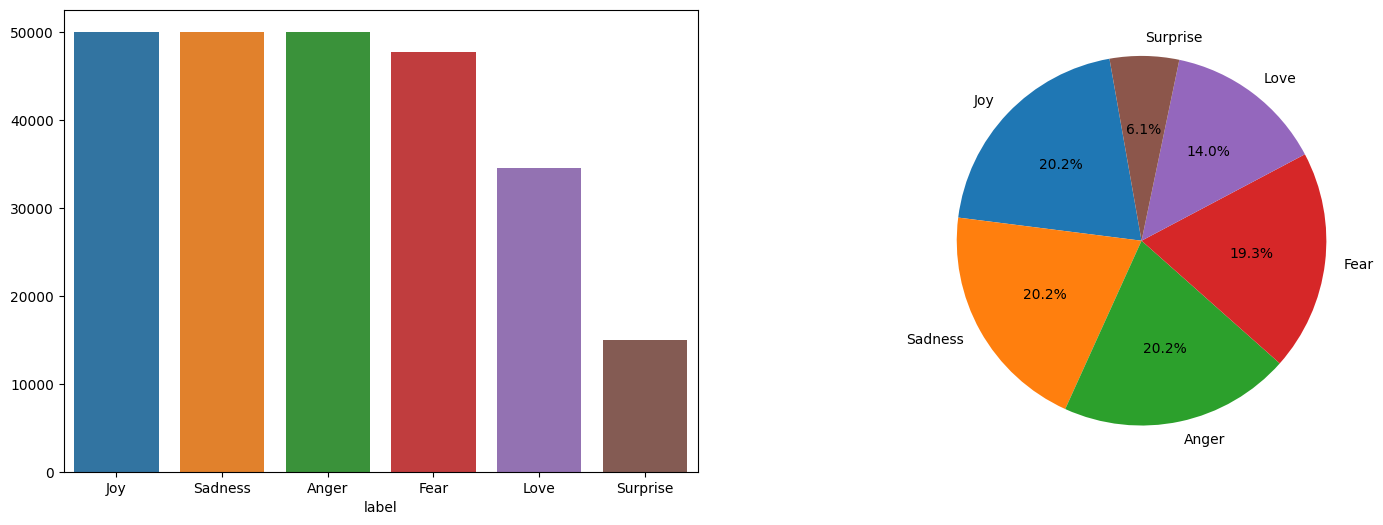

In [17]:
counts = data['label'].value_counts()

label_names = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'

}

counts.index = counts.index.map(label_names)

fig, axs = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')

sns.barplot(x=counts.index, y=counts.values, ax=axs[0])
axs[1].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=100)
plt.show()

In [49]:
X = data['text']
y = data['label']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) # stratify=data['label']

In [51]:
print(f'Train data: {len(X_test)}')
print(f'Test data: {len(y_test)}')

Train data: 49448
Test data: 49448


# 3. Tokenization and data preparation:
 - Performed tokenization and text-to-sequence conversion using text-to-sequence and pad-sequence methods to normalize the length of texts.
 - Converted target variables (labels) using get_dummies method to get multi-class label.

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 75303


In [53]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [54]:
X_train = pad_sequences(X_train, maxlen=max_length_preprocessed)
X_test = pad_sequences(X_test, maxlen=max_length_preprocessed)

In [55]:
X_train.shape, X_test.shape

((197790, 480), (49448, 480))

In [56]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [57]:
print("Training Y Shape:",y_train.shape)
print("Testing Y Shape:",y_test.shape)

Training Y Shape: (197790, 6)
Testing Y Shape: (49448, 6)


In [27]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-09 11:22:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-09 11:22:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-09 11:22:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: '/tmp/glove.6B.zip'


In [28]:
from keras.layers import Dense, Flatten, Embedding,Conv1D, MaxPooling1D,Input,Concatenate,SimpleRNN, GRU,Bidirectional,LSTM,concatenate, Dropout, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, AdamW, Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold

In [29]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

# 4. Using the embeddings layer:
 - Connected the GloVe Embeddings layer withsizey 300 to take advantage of the pre-trained word representations.

In [30]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [31]:
embedding_dim = 300  # или другая размерность эмбеддингов
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Вставляем эмбеддинг в матрицу
        embedding_matrix[i] = embedding_vector


#  5. Model building and training:
 - Built a simple neural network for classification using bidirectional LSTM with dropout and recurrent dropout values of 0.2 to prevent overfitting.
 - A Dense layer with six neurons and softmax activation function was used as output layer to obtain the probability of text belonging to each class.
 - Trained the model and verified its performance on training and test datasets.

In [32]:
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_length_preprocessed,
                            trainable=False)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 480, 300)       │    22,590,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,778,554 (86.89 MB)

 Trainable params: 187,654 (733.02 KB)

 Non-trainable params: 22,590,900 (86.18 MB)

Epoch 1/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1109s 894ms/step - accuracy: 0.6780 - loss: 0.8598 - val_accuracy: 0.9163 - val_loss: 0.2080 - learning_rate: 0.0010
Epoch 2/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1096s 886ms/step - accuracy: 0.9085 - loss: 0.2303 - val_accuracy: 0.9310 - val_loss: 0.1486 - learning_rate: 0.0010
Epoch 3/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1104s 892ms/step - accuracy: 0.9248 - loss: 0.1712 - val_accuracy: 0.9364 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 4/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1095s 885ms/step - accuracy: 0.9318 - loss: 0.1458 - val_accuracy: 0.9398 - val_loss: 0.1242 - learning_rate: 0.0010
Epoch 5/5
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1099s 889ms/step - accuracy: 0.9366 - loss: 0.1335 - val_accuracy: 0.9377 - val_loss: 0.1202 - learning_rate: 0.0010
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 348s 225ms/step - accuracy: 0.9390 - loss: 0.1202
Test Loss: 0.12037912011146545
Test Accuracy: 0.9389257431030273
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 352s 228ms/step


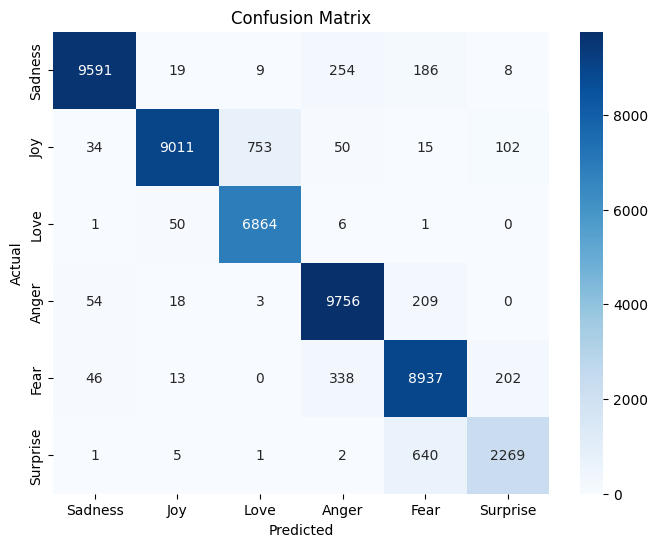

              precision    recall  f1-score   support

     Sadness       0.99      0.95      0.97     10067
         Joy       0.99      0.90      0.94      9965
        Love       0.90      0.99      0.94      6922
       Anger       0.94      0.97      0.95     10040
        Fear       0.89      0.94      0.92      9536
    Surprise       0.88      0.78      0.83      2918

    accuracy                           0.94     49448
   macro avg       0.93      0.92      0.93     49448
weighted avg       0.94      0.94      0.94     49448



In [58]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)

# Define the model
sequence_input = Input(shape=(max_length_preprocessed,))
#embedding_sequences = embedding_layer(sequence_input)


embedding_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedding_sequences)
outputs = Dense(6, activation='softmax')(x)


# Create the model
model = Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(X_train, y_train,
                    callbacks=[reduce_lr],
                    batch_size = 128,
                    epochs=5,
                    validation_split=0.2)
                    #validation_data=(x_test,y_test_encoded))# callbacks=[early_stopping],

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict the classes
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names.values()))

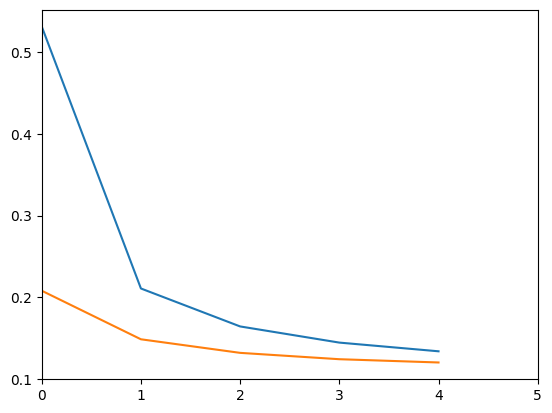

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlim(0,5)
plt.show()

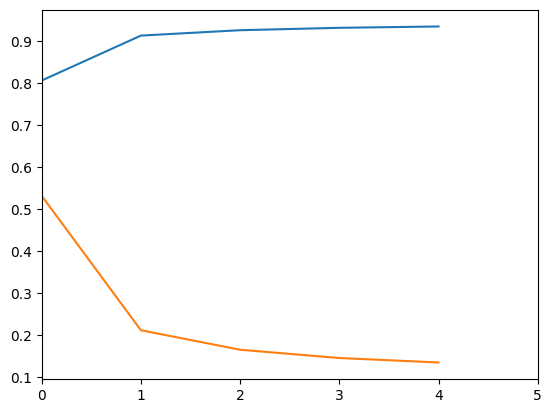

In [113]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlim(0,5)
plt.show()

#  6. Evaluation of results:
 - Tested the model on all data to make sure that the model does not just “remember” the data, but has the ability to generalize.
 - Saved the trained model for future use.

In [60]:
X = data['text']
y = data['label']

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_length_preprocessed)
y = pd.get_dummies(y, dtype=int)

7727/7727 ━━━━━━━━━━━━━━━━━━━━ 1755s 227ms/step


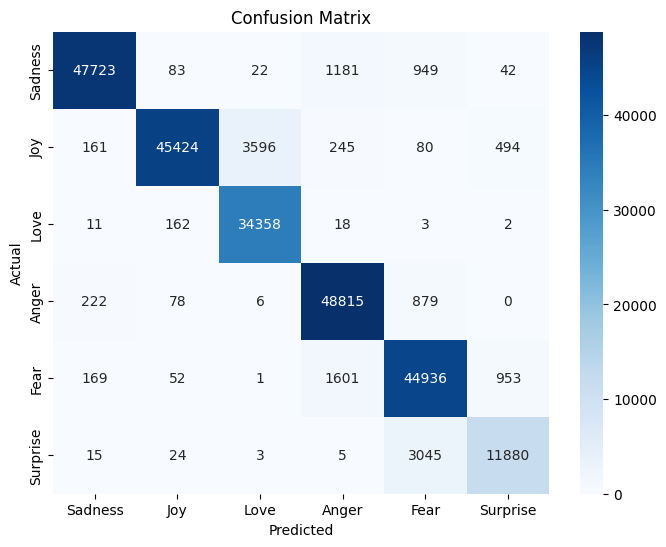

              precision    recall  f1-score   support

     Sadness       0.99      0.95      0.97     50000
         Joy       0.99      0.91      0.95     50000
        Love       0.90      0.99      0.95     34554
       Anger       0.94      0.98      0.96     50000
        Fear       0.90      0.94      0.92     47712
    Surprise       0.89      0.79      0.84     14972

    accuracy                           0.94    247238
   macro avg       0.94      0.93      0.93    247238
weighted avg       0.94      0.94      0.94    247238



In [61]:
# Predict the classes
y_pred = np.argmax(model.predict(X), axis=-1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names.values()))

In [105]:
model.save('emotions_model_03_final.h5')

In [106]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_file:
    json_file.write(tokenizer_json)

In [107]:
from tensorflow.keras.models import load_model

model1 = load_model('emotions_model_03_final.h5')

In [108]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

with open('tokenizer.json') as json_file:
    tokenizer_data = json.load(json_file)
    tokenizer_json = json.dumps(tokenizer_data)  # Convert dict to JSON string
    tokenizer = tokenizer_from_json(tokenizer_json)

In [109]:
def emotion_detection(text):
    text = [text] if isinstance(text, str) else text
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=480)
    pred = np.argmax(model1.predict(text), axis=-1)
    #print(pred[0])

    match pred[0]:
        case 0:
            pred_str = 'Sadness'
        case 1:
            pred_str = 'Joy'
        case 2:
            pred_str = 'Love'
        case 3:
            pred_str = 'Anger'
        case 4:
            pred_str = 'Fear'
        case 5:
            pred_str = 'Surprise'
            
    return pred_str
    
    

In [110]:
user_t = input("Write your text: ")
emotion_detection(user_t)

Write your text:  I have a big presentation tomorrow, and I’m really nervous


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


'Fear'

# Results

 - The model showed good classification performance on balanced data. Removing redundant elements in the data helped to avoid overtraining on specific classes, which had a positive impact on the results.
 - The use of a pre-trained GloVe layer improved text representation and classification quality.
 - The simple neural network architecture with bidirectional LSTM performed well on this task.